## **Tesla stock price time-series analysis with RNNs**

The objective of this exercise is to predict the stock price of Tesla using historical data. A basic project that focuses on using tactics from ML and blend them with Deep Learning to create a Time Series Analysis Model using RNN variants, such as the LSTM and GRU.

### **RNNs**
The **recurrent neural network**
is preferred to the vanilla neural network for these reasons:
- Information decay - as data sequences get longer, the vanilla RNN loses information from previous inputs
- Vanishing gradient - during backpropagation, with each pass, the model's capacity to learn is reduced as the gradient shrinks, preventing the network from learning long-range dependencies.

### **LSTM (Long Short-Term Memory)**
A type of recurrent neural network (RNN) designed to handle sequences of data, especially when long-term dependencies are required. Applications LSTMs are used in include time series prediction, natural language processing (NLP) and speech recognition. The LSTM's ability to selectively keep and discard information from previous inputs makes it powerful for the above tasks.

A traditional RNN has a simple structure of input, hidden state and output. An LSTM rivals this better by having a more complex architecture; more memory cells and gates.

LSTMs use three types of gates, namely
1. Forget Gate decides which information to selectively discard from the cell state. It controls the flow of information from the previous memory cell into the current memory cell.
2. Input Gate updates the cell state with new information from the current input.
3. Output Gate determines what the next hidden state will be, which influences the output and the next time step

### **About the dataset**
Tesla is an American electric vehicle and clean energy company. This dataset contains historical data of its stock, TSLA, beginning from 29 June 2010 and ending in 24 March 2022.

The `TSLA.csv` dataset contains the following columns:
- Date
- Open: Price from the first transaction of a trading day
- High: Maximum price in a trading day
- Low: Minimum price in a trading area
- Close: Price from the last transaction of a trading day
- Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
- Volume: Number of units traded in a day

Disclaimer: This exercise was run on Google Colab.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# To standardize numerical features by scaling them
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("TSLA.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [4]:
# Convert the Date column from an object type to a datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Remove the adjusted close price column as it is very similar to the "Close" column;
# we want the model to predict future closing price based on other features
data = data.drop(columns = "Adj Close")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2956 non-null   datetime64[ns]
 1   Open    2956 non-null   float64       
 2   High    2956 non-null   float64       
 3   Low     2956 non-null   float64       
 4   Close   2956 non-null   float64       
 5   Volume  2956 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 138.7 KB


### **Building a time series model**

The model type is Sequential, as it should be to analyze time series data. The type ("Sequential") is specified during intialization when the model has nothing to it, kinda like an empty box.

After initalization, build on the model by adding layers to it.

In [ ]:
# Check if there is any correlation between the numeric features
# Preview all the columns
print(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


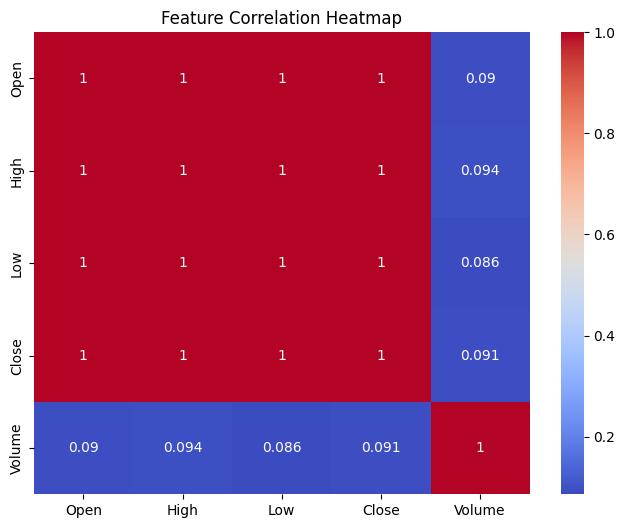

In [ ]:
# Check correlation between numerical columns
plt.figure(figsize=(8,6))
subset = data[['Open', 'High', 'Low', 'Close', 'Volume']]
sns.heatmap(subset.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

The visualization above shows that there is very high correlation between five of the numerical features, namely the opening, high, low and closing price.

In [ ]:
# The starting and ending duration
print(data['Date'][0])
print(data['Date'][len(data)-1])

2010-06-29 00:00:00
2022-03-24 00:00:00


<Axes: xlabel='Date'>

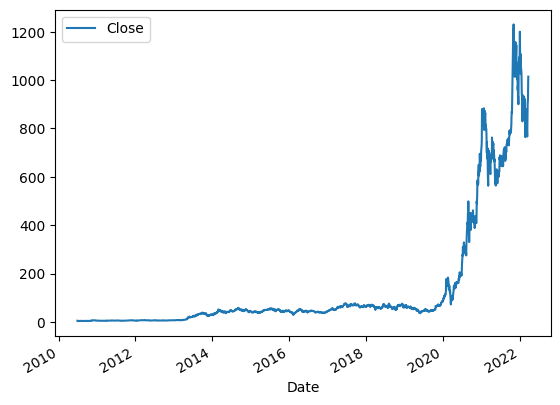

In [ ]:
# Plot the closing price against date
data.plot(x="Date", y="Close")

<Axes: xlabel='Date'>

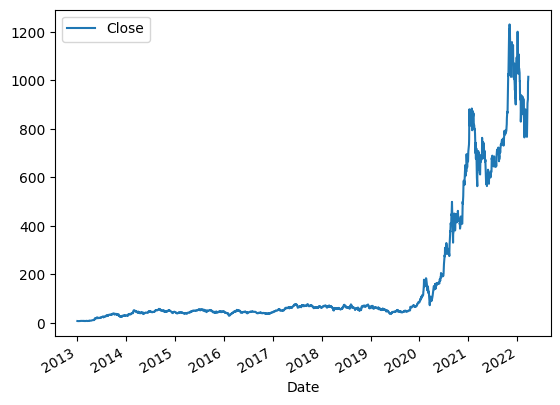

In [5]:
# Suppose we want to take a subset of the data after 2013
# To remove the time frame between 2010 and 2013 as there are negligible changes
import datetime
data = data.loc[
    (data['Date'] >= '2013, 1, 1')
]

# Plot again
data.plot(x = "Date", y = "Close")

In [6]:
# Prepare for the RNN models (we want the model to predict the future closing price)
data_close = data.filter(["Close"])

# Convert this to a numpy array
data_closenp = data_close.values

# Training data is 90% of the data
# The test data is the remaining 10% (predicted/projected forecast)
train_len = int(np.ceil(len(data_closenp) * 0.90))

# Preprocessing stage (first to scale the data)
# StandardScaler() scales data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_closenp)
# Obtain the training data as a 90% subset of the original data
training_data = scaled_data[:train_len]

X_train, y_train = [], []

# A sliding window for the closing price of 60 days
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

# Convert the lists to numpy arrays as TF only handles np arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape to a 3D array/ reshape the data to 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0],
                               X_train.shape[1], 1))

### **A stacked LSTM**

Instead of a single LSTM layer, produce a stacked LSTM, a model with multiple LSTM layers. In this context, I will use only 2 LSTM layers, where one layer provides the following layer a sequential output. As there is no processing of categorical data (words in NLP), I will not be using the `keras.layers.Embedding` layer.

1. First layer: The initial layer acts as a brain to understand patterns. The general syntax of code is below:
`model.add(keras.layers.LSTM(64, return_sequences=True/False, input_shape=(3D array dim)))`
- First argument is the number of memory cells. The higher the number, the more complex patterns the model can capture
- Second argument is the full list of ideas for the next layer. As it is set to `True`, it means that the next layer will receive a sequence, this is for multi-layer LSTM models.
- Third argument tells the first layer what dimensions of data to expect

2. Second layer: This gives the final idea. `model.add(keras.layers.LSTM(64, return_sequences=False))`. In this layer, it distills the important patterns from the first layer and prepares to make a final prediction. The second argument set to `False` indicates to the model to return a single output instead of a sequence.


3. Dense layer: Turns complex patterns into a decision, while refining its understanding of the data to learn more complicated trends.
`model.add(keras.layers.Dense(128, activation='relu'))`. This is a regular neural network layer with 128 neurons to make the final decision. The activation function is to introduce non-linearity to the data.

4. Dropout layer: Drops a percentage of the neurons randomly during training to prevent overfitting (when the model memorizes the data too well but struggles with new data)
`model.add(keras.layers.Dropout(0.5))` keeps the model from being too sensitive to the training data and helps it perform better by randomly dropping 50% of the neurons.

5. Final dense layer: makes the final prediction. A layer with one neuron that outputs the predicted weather data.

This is one variation of an LSTM model using Keras, and there are other variations and customizations to explore.

### **Model compilation**
Compiles the model to tell it how to learn. The way the model learns is attributed to the following features below, namely:
- An optimizer helps the model adjusts its learning. Sometimes, the learning rate will be specified to increase the rate of convergence of the model's performance.
- The mean absolute error (MAE) will be the loss function
- The mean squared error will be the performance metric that checks how accurate the model is in predicting.

There are other optimizers, loss functions and metrics that can be considered for exploration and optimizing the model.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Define the LSTM model
model = Sequential()

# Start building the model/stacking the layers
# First layer (LSTM)
model.add(LSTM(64, return_sequences=True,
                input_shape = (X_train.shape[1], 1)))

# Second layer (LSTM receiving from previous layer)
model.add(LSTM(64, return_sequences=False))

# Third layer (Dense: densely connected NN)
model.add(Dense(128, activation = 'relu'))

# Fourth layer (Dropout to prevent overfitting)
model.add(Dropout(0.5))

# Final output layer (Dense) with only 1 neuron to produce output
model.add(Dense(1))

# Display each layer of the model, showing the shape of each layer's
# output and the number of parameters in each layer
model.summary()

# Compile the model
model.compile(optimizer = "adam",
              loss = "mae",
              metrics = [keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To train the model by fitting the data to it
# epochs: number of times the LSTM runs to find the best solution
# batch_size: amount of data that is in a batch when it runs
training = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

# Prep the test data
test_data = scaled_data[train_len - 60:]
X_test, y_test = [], data_closenp[train_len:]

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2354 - root_mean_squared_error: 0.3872
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0890 - root_mean_squared_error: 0.1495
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0798 - root_mean_squared_error: 0.1375
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0683 - root_mean_squared_error: 0.1170
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0665 - root_mean_squared_error: 0.1150
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0719 - root_mean_squared_error: 0.1246
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0613 - root_mean_squared_error: 0.1026
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0588 - root_mean_squared_error: 0.1026
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0599 - root_mean_squared_error: 0.1082
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0617 - root_mean_squared_error: 0.1091
Epoch

In [13]:
# Using the same window approach
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Similarly, for the test set, convert to a 3D np array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Make a prediction on the 10% test set
pred = model.predict(X_test)

# Downscale/revert back to the original scale for visualizing the predictions
pred = scaler.inverse_transform(pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


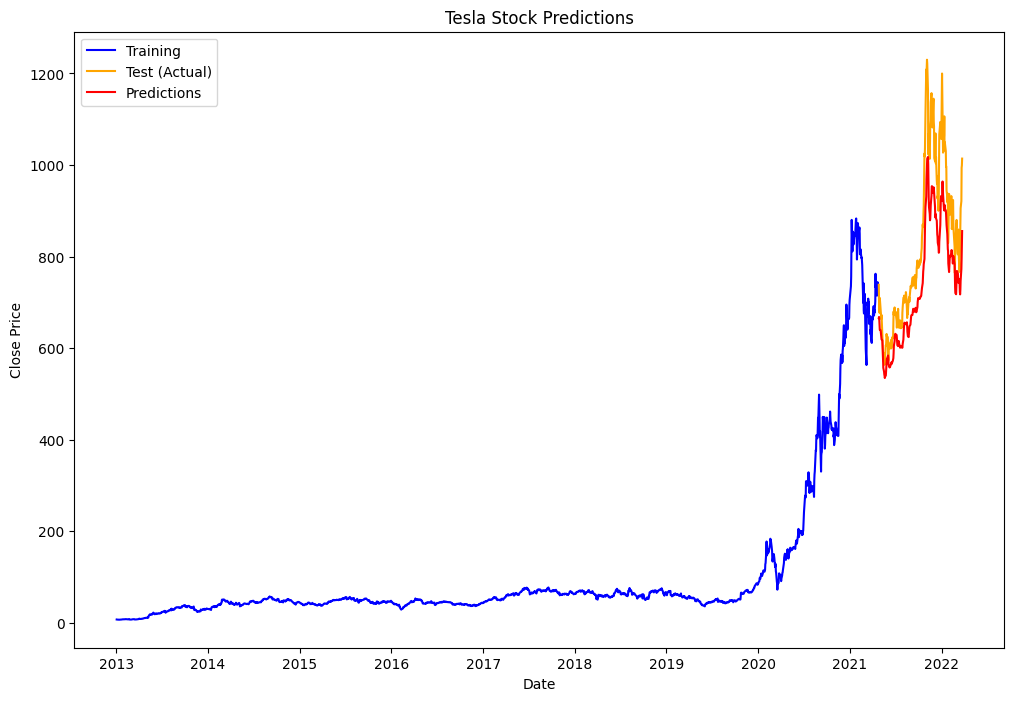

In [ ]:
# Plotting the visualization/showing the predicted against the actual
train = data[:train_len]
test = data[train_len:]
test = test.copy()

# Add a seperate column for the predictions
test['Predictions'] = pred
plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['Close'], label="Training", color='blue')

# Plot actual vs prediction
plt.plot(test['Date'], test['Close'], label="Test (Actual)", color='orange')
plt.plot(test['Date'], test['Predictions'], label="Predictions", color='red')
plt.title("Tesla Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

From the mean squared error quantities and the figure, this LSTM model proves to be fairly effective in predicting the future closing price of the Tesla stock based on historical data.

While the sizes of increases and decreases in the predicted closing price are significantly different from the actual, the trends are slightly similar. This is the predicted closing price using a stacked LSTM model.

### **Evaluation**
It is worth noting that on using the full dataset before this experiment, and training LSTM on 90% of the data, the results were actually better; generally a lower MSE (mean squared error) across the epochs, and the predicted closing price graph is still under the actual price graph, but closer. It might be apparent that the larger the data size being fed to the model, the more accurate the predictions.

Attempts to improve the accuracy of predictions can be explored by tweaking the LSTM architecture (rearranging the layers and possibly adding more layers), the optimizer (add learning rate?), the number of epochs, the batch size, the activation function in the layers and the loss function.

### **Gated Recurrent Unit**
In this section, the same dataset will be trained and tested using the GRU in similar fashion. The GRU is a simpler version of the LSTM; it has a simpler architecture and thus, fewer parameters to train, making it computationally cheaper and faster. Just like LSTMs, GRUs model sequential data as they selectively keep and discard information over time.

GRUs do not have a memory cell state and 3 gates like in the LSTM, instead they have a "hidden state" and two gates:
- The reset gate is just like the forget gate in LSTM, limiting the flow of information from the previous state. This gate captures short-term dependencies in sequences.
- The update gate determines how much of the old state is copied over to the new state. This gate captures long-term dependencies.

The GRU is built in the same fashion as the stacked LSTM model above.

In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

model_gru = Sequential()

# Add first GRU layer, followed by a second GRU layer
model_gru.add(GRU(64, return_sequences=True,
                  input_shape = (X_train.shape[1], 1)))
model_gru.add(GRU(64, return_sequences = False))

# fully connected nn
model_gru.add(Dense(128, activation = 'relu'))

# Fourth layer, add dropout
model_gru.add(Dropout(0.5))

# Final output layer (Dense) with only 1 neuron to produce output
model_gru.add(Dense(1))

# Display each layer of the model, showing the shape of each layer's
# output and the number of parameters in each layer
model_gru.summary()

# Compile the model
model_gru.compile(optimizer = "adam",
              loss = "mae",
              metrics = [keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,273 (180.75 KB)

 Trainable params: 46,273 (180.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model (Ran on CPU, unlike GPU for the LSTM, hence the longer time per epoch)
training_gru = model_gru.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.2348 - root_mean_squared_error: 0.4021
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0769 - root_mean_squared_error: 0.1222
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0697 - root_mean_squared_error: 0.1200
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0705 - root_mean_squared_error: 0.1296
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0636 - root_mean_squared_error: 0.1117
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0663 - root_mean_squared_error: 0.1126
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0628 - root_mean_squared_error: 0.1121
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0593 - root_mean_squared_error: 0.1056
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0575 - root_mean_squared_error: 0.0967
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0611 - root_mean_squared_error: 

In [15]:
# Make a prediction on the 10% test set
pred_gru = model_gru.predict(X_test)

# Downscale/revert back to the original scale for visualizing the predictions
pred_gru = scaler.inverse_transform(pred_gru)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


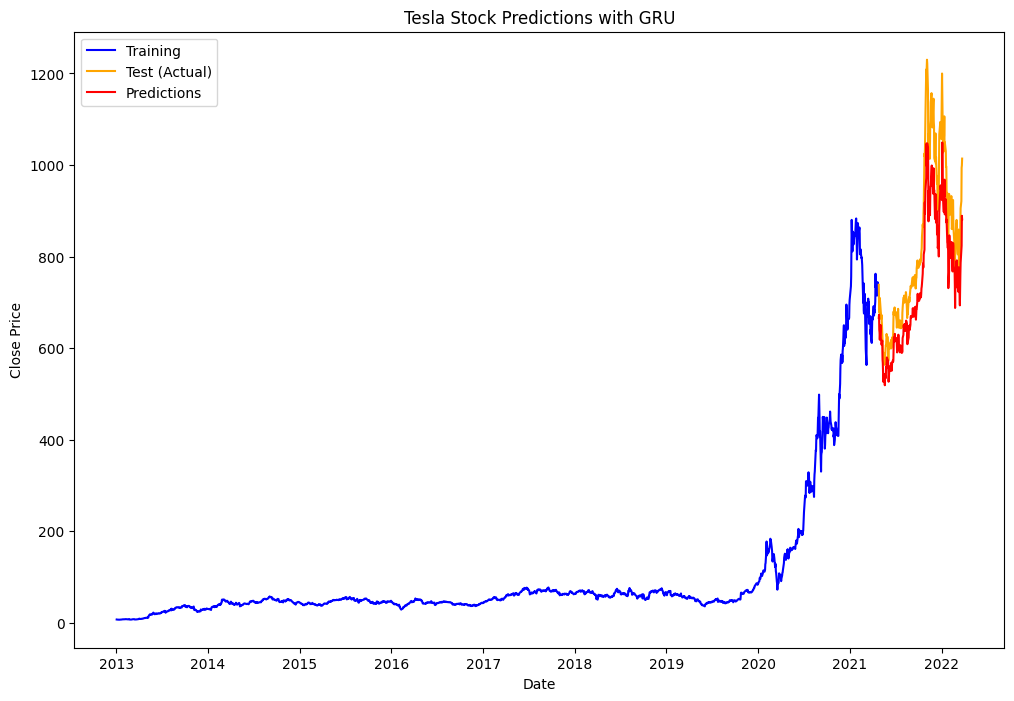

In [16]:
# Plotting the visualization/showing the predicted against the actual
train = data[:train_len]
test = data[train_len:]
test = test.copy()

# Add a seperate column for the predictions
test['Predictions'] = pred_gru
plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['Close'], label="Training", color='blue')

# Plot actual vs prediction
plt.plot(test['Date'], test['Close'], label="Test (Actual)", color='orange')
plt.plot(test['Date'], test['Predictions'], label="Predictions", color='red')
plt.title("Tesla Stock Predictions with GRU")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Interestingly enough, the performance of the GRU model, built in a similar fashion to the stacking of the LSTM layers, has about the same performance as the stacked LSTM model. Both forecasted trends appear very close to each other.

### **Work in progress**

In the following section, there could be changes to how to implement the LSTM/GRU models (rearranging of layers). This is now entirely on exploration and optimization as creating a basic model is done.